In [1]:
from pathlib import Path
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm

import numpy as np
import numpy

import torch
import torch.nn as nn

In [2]:
########### PARAMS ############
BINS = 256
LAYERS = [(4, 5), (5, 5), (5, 3)]
ACTIVATION = nn.ReLU()
RUNS = 3
FREQUENCY = 5 # epochs per measurement
EPOCHS = 400
# BATCH_SIZE = 10 this is fixed

top_str = "relu"
for i, l in enumerate(LAYERS):
    if i == len(LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

In [3]:
top_str

'relu4-5-5-3'

In [4]:
here = Path()
run_folders = list(here.glob("run*-frames"))
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('run6-frames'), PosixPath('run3-frames'), PosixPath('run12-frames')]


In [5]:
figures = here / f"figures_{top_str}"
if not figures.exists():
    figures.mkdir()

In [6]:
# Pretty colormaps
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))

def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def makeColor(collection, item, cmap = "rainbow"):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap(cmap)
    return colormap((((0.6 / size * pos) + 0.3)))

def infernoMap(i, n): # i = 1, 2, ... n
    colormap = matplotlib.cm.get_cmap("inferno")
    return colormap((1.0 * i / n)*0.6 + 0.0)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

In [7]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epoch',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
    ]
    for i in range(1, len(LAYERS)+1):
        measure_names.append(f"ei_layer{i}")
        measure_names.append(f"sensitivity_layer{i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [8]:
runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for run_datapoints in runs_datapoints:
    run_datapoints.sort(key=lambda f: f['batches'])

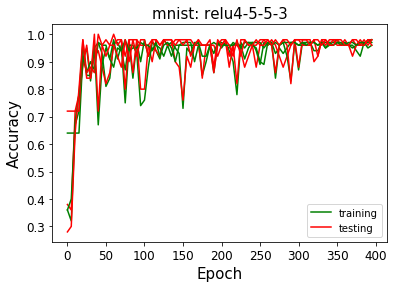

In [9]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epoch'] for f in run]
    training_accuracies = [f['training_accuracy'] for f in run]
    testing_accuracies = [f['testing_accuracy'] for f in run]
    if i == 0:
        plt.plot(epochs, training_accuracies, color='green', alpha=1, label='training')
        plt.plot(epochs, testing_accuracies, color='red', alpha=1, label='testing')
    else:
        plt.plot(epochs, training_accuracies, color='green', alpha=1)
        plt.plot(epochs, testing_accuracies, color='red', alpha=1)
plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='lower right')
#plt.savefig(f"{figures}/mnist_{top_str}_accuracies.png", dpi=300, bbox_inches='tight')

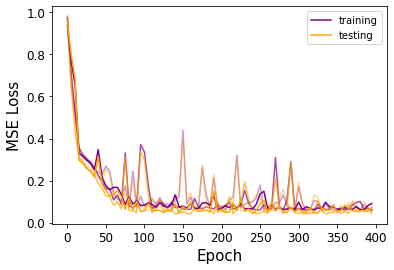

In [14]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epoch'] for f in run]
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 2:
        plt.plot(epochs, training_losses, color='purple', label='training', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', label='testing', alpha=0.4 + 0.3*i)
    else:
        plt.plot(epochs, training_losses, color='purple', alpha=0.4 + 0.3*i)
        plt.plot(epochs, testing_losses, color='orange', alpha=0.4 + 0.3*i)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='upper right')
# plt.yscale('log')
plt.savefig(f"{figures}/iris_{top_str}_losses_final.png", dpi=300, bbox_inches='tight')

In [9]:
for run in runs_datapoints:
    for frame in run:
        frame['sensitivity_layer2'] = frame['sensitivity_layer2'][0]
        frame['ei_layer3'] = frame['ei_layer3'][0]

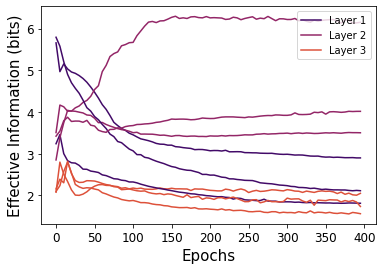

In [15]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs_datapoints):
    batches = [f['batches'] for f in run]
    epochs = [f['epoch'] for f in run]
    for l in range(1, len(LAYERS)+1):
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        line, = ax.plot(epochs, ei_layer, c=infernoMap(l, len(LAYERS)))
        if i == 0:
            line.set_label(f"Layer {l}")

#ax.set_xlabel('Epoch',fontsize=15)    
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel('Effective Information (bits)',fontsize=15)
# ax.set_title(f"mnist: {top_str}", fontsize=15)
# ax.set_xlim([-3, 13])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
# noEIChange, = ax.plot([0,0],[200,1600],c = 'black', label="EI nullcline")
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.66),prop={'size':10})
# fig.legend(loc=(.17, 0.72),prop={'size':10})
ax.legend(loc='upper right')
ax.tick_params(axis='both',which='major',labelsize=12)
plt.savefig(f"{figures}/iris_{top_str}_eis_each-final.png", dpi=300, bbox_inches='tight')

In [29]:
# for run in runs:
#     batches = [f['num_batches'] for f in run]
#     ei_layer1s = np.array([f['ei_layer1'] for f in run])
#     sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
#     ei_layer2s = np.array([f['ei_layer2'] for f in run])
#     sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
#     ei_layer3s = np.array([f['ei_layer3'] for f in run])
#     sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
#     degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
#     degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
#     degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
#     plt.plot(batches, ei_layer1s, label="1", color=infernoMap(1, 3))
#     plt.plot(batches, ei_layer2s, label="2", color=infernoMap(2, 3))
#     plt.plot(batches, ei_layer3s, label="3", color=infernoMap(3, 3))


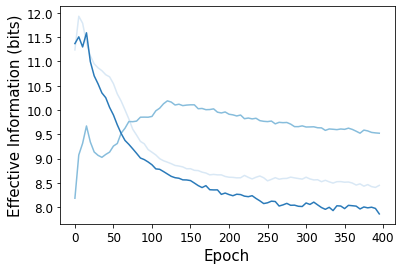

In [20]:
fig, ax = matplotlib.pyplot.subplots(1,1)
eis_each_run = []
for run in runs_datapoints:
    batches = [f['batches'] for f in run]
    epochs = [f['epoch'] for f in run]
    layer_eis = []
    for i in range(1, len(LAYERS)+1):
        layer_eis.append(np.array([f[f"ei_layer{i}"] for f in run]))
    eis_each_run.append(layer_eis)
        
total_eis = []
for run_eis in eis_each_run:
    tot = 0
    for layer_eis in run_eis:
        tot += layer_eis
    total_eis.append(tot)
    
for i, ei in enumerate(total_eis):
    epochs = [f['epoch'] for f in runs_datapoints[i]]
    plt.plot(epochs, ei, color=blueMap([0, 1, 2], i))#color=infernoMap(1, 3))

# plt.title(f"mnist: {top_str}", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
# plt.legend(loc='lower right')
# plt.legend()
# plt.savefig(f"{figures}/iris_{top_str}_eis_total_final.png", dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = matplotlib.pyplot.subplots(1,1)  
for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s

In [35]:
# fig, ax = matplotlib.pyplot.subplots(1,1)  

# for i, run in enumerate(runs):
#     batches = [f['num_batches'] for f in run]
#     ei_layer1s = np.array([f['ei_layer1'] for f in run])
#     sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
#     ei_layer2s = np.array([f['ei_layer2'] for f in run])
#     sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
#     ei_layer3s = np.array([f['ei_layer3'] for f in run])
#     sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
#     degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
#     degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
#     degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    
#     line, = ax.plot(sensitivity_layer1s, degeneracy_layer1s, c=infernoMap(1, 3))
#     if i == 0:
#         line.set_label("Layer 1")

#     line, = ax.plot(sensitivity_layer2s, degeneracy_layer2s, c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("Layer 2")

#     line, = ax.plot(sensitivity_layer3s, degeneracy_layer3s, c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("Layer 3")
# #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))

# #ax.set_xlabel('Epoch',fontsize=15)            
# ax.set_ylabel('Degeneracy',fontsize=15)
# ax.set_xlabel("Sensitivity", fontsize = 15)
# ax.set_title("IRIS w/ Correct Labels", fontsize=15)
# # ax.set_xlim([-3, 13])
# # ax.set_ylim([5,25])
# #ax.set_ylim([0,70])
# # Plot a vertical line!
# # noEIChange, = ax.plot([0,0],[200,1600],c = 'black', label="EI nullcline")
# # noEIChange, = ax.plot([0,0],[2,6], c='black')
# # noEIChange.set_label("EI nullcline")
# # Plot the legend!
# # fig.legend(loc=(.18,0.645),prop={'size':10})
# fig.legend(loc=(.17, 0.72),prop={'size':10})
# ax.tick_params(axis='both',which='major',labelsize=12)
# #fig.legend(loc='upper left')
# plt.savefig("figures/iris_plane_nonrotated_all_correct.png", dpi=300, bbox_inches='tight')

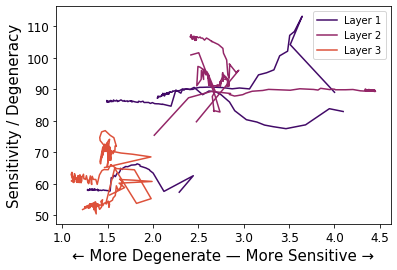

In [22]:
fig, ax = matplotlib.pyplot.subplots(1,1) 

for l in range(1, len(LAYERS)+1):
    for i, run in enumerate(runs_datapoints):
        ei_layer = np.array([f[f"ei_layer{l}"] for f in run])
        sensitivity_layer = np.array([f[f"sensitivity_layer{l}"] for f in run])
        degeneracy_layer = sensitivity_layer - ei_layer
        xS = sensitivity_layer
        yS = degeneracy_layer
        xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
        line, = ax.plot(xPrime, yPrime, c=infernoMap(l, len(LAYERS))) #alpha=0.25+0.37*i)
        if i == 0:
            line.set_label(f"Layer {l}")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# plt.title(f"mnist: {top_str}", fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
ax.legend()
# plt.savefig("figures/iris_plane_all_correct.png", dpi=300, bbox_inches='tight')


# #ax.set_xlabel('Epoch',fontsize=15)            
# ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
# ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# plt.title("IRIS w/ Correct Labels", fontsize=15)
# ax.tick_params(axis='both',which='major',labelsize=12)
# ax.set_xlim([-2, 14])
# # ax.set_ylim([5,25])
# #ax.set_ylim([0,70])
# # Plot a vertical line!
# noEIChange, = ax.plot([0,0],[250, 1650], c = 'black', label='EI nullcline')
# # noEIChange, = ax.plot([0,0],[2,6], c='black')
# # noEIChange.set_label("EI nullcline")
# # Plot the legend!
# fig.legend(loc=(.27,0.66),prop={'size':10})
# #fig.legend(loc=(.135,0.645),prop={'size':10})
plt.savefig(f"{figures}/iris_{top_str}_plane.png", dpi=300, bbox_inches='tight')

In [24]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

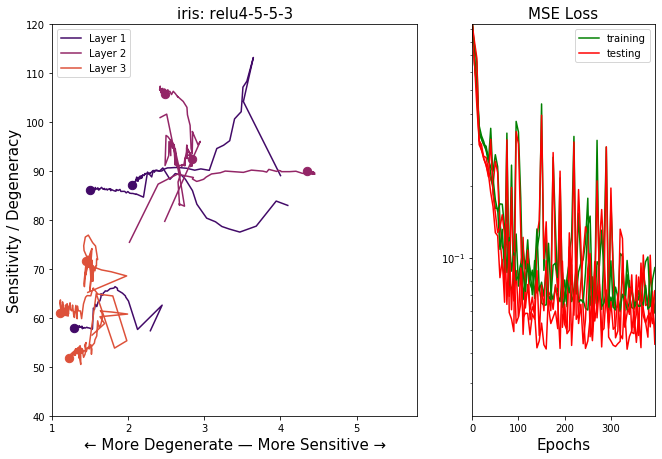

In [25]:
LENGTH = len(runs_datapoints[0])

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"iris: {top_str}", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(10.8, 7.2))
ax.set_title(f"iris: {top_str}", fontsize=15)
ax.set_ylabel('Sensitivity / Degeneracy', fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize=15)
ax.set_xlim([1, 5.8])
ax.set_ylim([40, 120])
ax2.set_xlabel("Epochs", fontsize=15)
ax2.set_title("MSE Loss", fontsize=15)
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

layer_lines = {}
layer_dots = {}
for l in range(1, len(LAYERS)+1):
    layer_lines[f"layer{l}"] = []
    layer_dots[f"layer{l}"] = []
    for i in range(RUNS):
        if i == 0:
            layer_lines[f"layer{l}"].append(ax.plot([], [], c=infernoMap(l, len(LAYERS)), label=f"Layer {l}")[0])
            layer_dots[f"layer{l}"].append(ax.scatter([], [], c=infernoMap(l, len(LAYERS)), s=70))
        else:
            layer_lines[f"layer{l}"].append(ax.plot([], [], c=infernoMap(l, len(LAYERS)))[0])
            layer_dots[f"layer{l}"].append(ax.scatter([], [], c=infernoMap(l, len(LAYERS)), s=70))

tr_loss_lines = []
te_loss_lines = []
for i in range(RUNS):
    if i == 0:
        tr_loss_lines.append(ax2.plot([], [], c='green', label='training')[0])
        te_loss_lines.append(ax2.plot([], [], c='red', label='testing')[0])
    else:
        tr_loss_lines.append(ax2.plot([], [], c='green')[0])
        te_loss_lines.append(ax2.plot([], [], c='red')[0])


# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, f"{figures}/mnist_{top_str}_plane_video.mp4", dpi=200):
    for n in range(LENGTH):
        for i, run in enumerate(runs_datapoints):
            epochs = [f['epoch'] for f in run]
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
            tr_loss_lines[i].set_data(epochs[0:n+1], training_loss[0:n+1])
            te_loss_lines[i].set_data(epochs[0:n+1], testing_loss[0:n+1])
            ax2.set_xlim(0, epochs[n])
            ax2.set_yscale('log')
            ax2.set_ylim(min(testing_loss.min(), training_loss.min())/2, max(testing_loss.max(), training_loss.max()))
            ax2.legend(loc="upper right")
            for l in range(1, len(LAYERS)+1):
                ei_layer = np.array([f[f'ei_layer{l}'] for f in run])
                sensitivity_layer = np.array([f[f'sensitivity_layer{l}'] for f in run])
                degeneracy_layer = sensitivity_layer - ei_layer
                xS = sensitivity_layer
                yS = degeneracy_layer
                xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)])
                yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)])
                layer_lines[f"layer{l}"][i].set_data(xPrime[0:n+1], yPrime[0:n+1])
                layer_dots[f"layer{l}"][i].set_offsets([xPrime[n], yPrime[n]])
            ax.legend(loc="upper left")
        writer.grab_frame()
plt.subplots_adjust(wspace=0.2)
#             ss[i].set_offsets([xPrime[n], yPrime[n]])
#             lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
#         tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
#         te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        
#         fig, ax = matplotlib.pyplot.subplots(1,1)

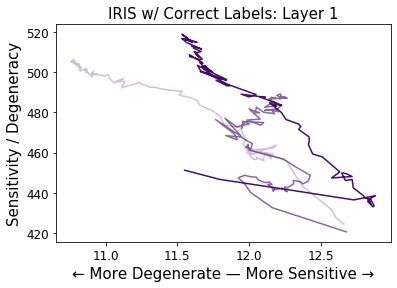

In [18]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    
#     diff = (sensitivity_layer1s[-1] - sensitivity_layer1s[0])
    xS = sensitivity_layer1s
    yS = degeneracy_layer1s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(1, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("1")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer2s
#     yS = degeneracy_layer2s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
# fig.legend(low='lower left')
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Correct Labels: Layer 1", fontsize=15)

plt.savefig("figures/iris_plane_layer1_correct.png", dpi=300, bbox_inches='tight')

In [16]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

In [17]:
l = len(batches)
print(l)

101


/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


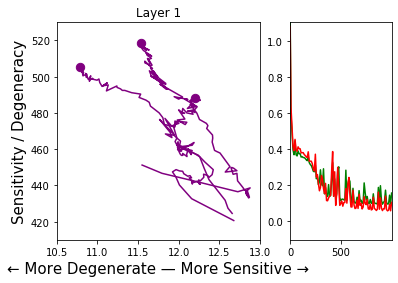

In [51]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 1")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([10.5, 13])
ax.set_ylim([410, 530])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer1_correct.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer1s = np.array([f['ei_layer1'] for f in run])
            sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
            degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer1s[-1] - sensitivity_layer1s[0])
            O = 50
            xS = sensitivity_layer1s
            yS = degeneracy_layer1s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)

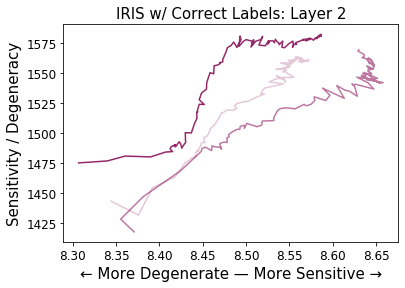

In [21]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s

#     diff = (sensitivity_layer2s[-1] - sensitivity_layer2s[0])
#     O = 75
    xS = sensitivity_layer2s
    yS = degeneracy_layer2s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(2, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer2s
#     yS = degeneracy_layer2s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Correct Labels: Layer 2", fontsize=15)
plt.savefig("figures/iris_plane_layer2_correct.png", dpi=300, bbox_inches='tight')

/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


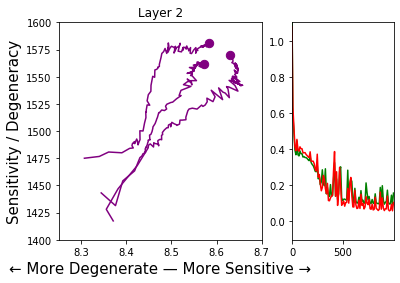

In [53]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 2")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([8.25, 8.7])
ax.set_ylim([1400, 1600])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer2_correct.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer2s = np.array([f['ei_layer2'] for f in run])
            sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
            degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer2s[-1] - sensitivity_layer2s[0])
            O = 50
            xS = sensitivity_layer2s
            yS = degeneracy_layer2s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)

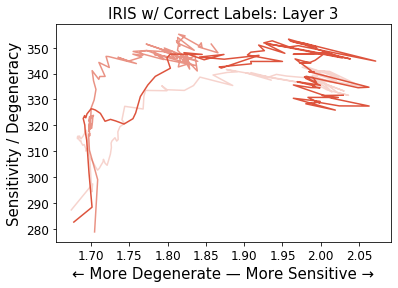

In [23]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s

#     diff = (sensitivity_layer2s[-1] - sensitivity_layer2s[0])
#     O = 50
    xS = sensitivity_layer3s
    yS = degeneracy_layer3s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(3, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer2s
#     yS = degeneracy_layer2s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Correct Labels: Layer 3", fontsize=15)
plt.savefig("figures/iris_plane_layer3_correct.png", dpi=300, bbox_inches='tight')

/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


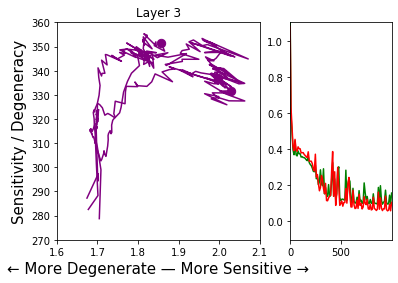

In [55]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 3")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([1.6, 2.1])
ax.set_ylim([270, 360])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer3_correct.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer3s = np.array([f['ei_layer3'] for f in run])
            sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
            degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer3s[-1] - sensitivity_layer3s[0])
            O = 50
            xS = sensitivity_layer3s
            yS = degeneracy_layer3s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)

# Now for the randomized labels:

In [24]:
run1 = here / "run1-256-bins-randomized/"
run2 = here / "run2-256-bins-randomized/"
run3 = here / "run3-256-bins-randomized/"

In [25]:
run1_frames = list(run1.glob('*.frame'))
run2_frames = list(run2.glob('*.frame'))
run3_frames = list(run3.glob('*.frame'))

In [26]:
run1_datapoints = [get_measures(path) for path in run1_frames]
run1_datapoints.sort(key=lambda f: f['num_batches'])
run2_datapoints = [get_measures(path) for path in run2_frames]
run2_datapoints.sort(key=lambda f: f['num_batches'])
run3_datapoints = [get_measures(path) for path in run3_frames]
run3_datapoints.sort(key=lambda f: f['num_batches'])

In [27]:
runs = [run1_datapoints, run2_datapoints, run3_datapoints]

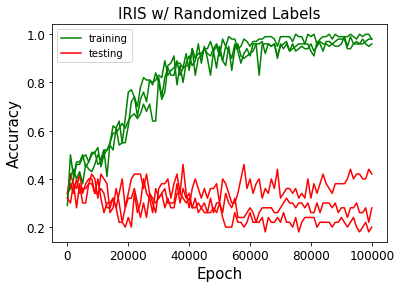

In [28]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    epochs = np.array(batches) / 2
    training_accuracies = [f['training_accuracy'] for f in run]
    testing_accuracies = [f['testing_accuracy'] for f in run]
    if i == 0:
        plt.plot(epochs, training_accuracies, color='green', alpha=1, label='training')
        plt.plot(epochs, testing_accuracies, color='red', alpha=1, label='testing')
    else:
        plt.plot(epochs, training_accuracies, color='green', alpha=1)
        plt.plot(epochs, testing_accuracies, color='red', alpha=1)
plt.title("IRIS w/ Randomized Labels", fontsize=15)
ax.set_xlabel('Epoch',fontsize=15)
ax.set_ylabel('Accuracy',fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='upper left')
# plt.savefig("figures/iris_accuracies_randomized.png", dpi=300, bbox_inches='tight')

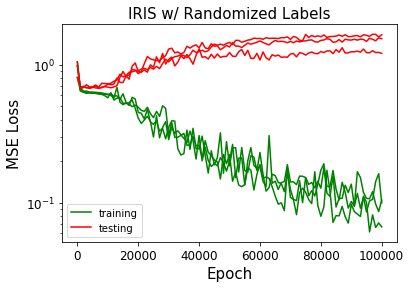

In [115]:
fig, ax = matplotlib.pyplot.subplots(1,1)
for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    epochs = np.array(batches) / 2
    training_losses = [f['training_loss'] for f in run]
    testing_losses = [f['testing_loss'] for f in run]
    if i == 0:
        plt.plot(epochs, training_losses, color='green', label='training', alpha=1)
        plt.plot(epochs, testing_losses, color='red', label='testing', alpha=1)
    else:
        plt.plot(epochs, training_losses, color='green', alpha=1)
        plt.plot(epochs, testing_losses, color='red', alpha=1)
plt.title("IRIS w/ Randomized Labels", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('MSE Loss', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
plt.legend(loc='lower left')
plt.yscale('log')
plt.savefig("figures/iris_losses_randomized.png", dpi=300, bbox_inches='tight')

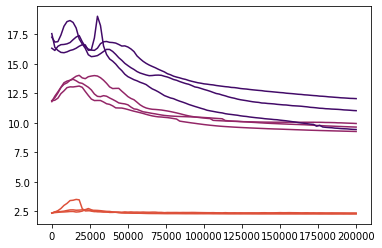

In [62]:
for run in runs:
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    plt.plot(batches, ei_layer1s, label="1", color=infernoMap(1, 3))
    plt.plot(batches, ei_layer2s, label="2", color=infernoMap(2, 3))
    plt.plot(batches, ei_layer3s, label="3", color=infernoMap(3, 3))


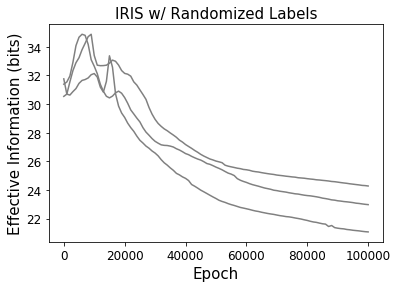

In [116]:
fig, ax = matplotlib.pyplot.subplots(1,1)
total_eis = []
for run in runs:
    batches = [f['num_batches'] for f in run]
    epochs = np.array(batches) / 2
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    total_eis.append(ei_layer1s + ei_layer2s + ei_layer3s)

for ei in total_eis:
    plt.plot(epochs, ei, color='grey')#color=infernoMap(1, 3))

plt.title("IRIS w/ Randomized Labels", fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
# plt.legend(loc='lower right')
# plt.legend()
plt.savefig("figures/iris_eis_randomized.png", dpi=300, bbox_inches='tight')

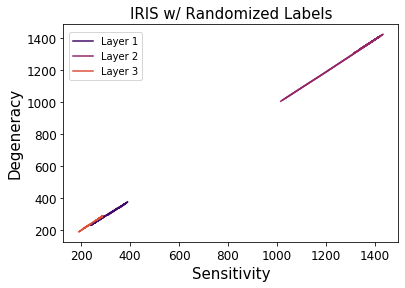

In [166]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    
    line, = ax.plot(sensitivity_layer1s, degeneracy_layer1s, c=infernoMap(1, 3))
    if i == 0:
        line.set_label("Layer 1")

    line, = ax.plot(sensitivity_layer2s, degeneracy_layer2s, c=infernoMap(2, 3))
    if i == 0:
        line.set_label("Layer 2")

    line, = ax.plot(sensitivity_layer3s, degeneracy_layer3s, c=infernoMap(3, 3))
    if i == 0:
        line.set_label("Layer 3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))

#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Degeneracy',fontsize=15)
ax.set_xlabel("Sensitivity", fontsize = 15)
ax.set_title("IRIS w/ Randomized Labels", fontsize=15)
# ax.set_xlim([-3, 13])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
# noEIChange, = ax.plot([0,0],[200,1600],c = 'black', label="EI nullcline")
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
fig.legend(loc=(.17, 0.72),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
#fig.legend(loc='upper left')
plt.savefig("figures/iris_plane_nonrotated_all_randomized.png", dpi=300, bbox_inches='tight')

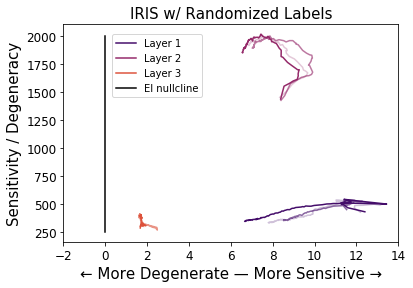

In [30]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
    
#     diff = (sensitivity_layer1s[-1] - sensitivity_layer1s[0])
    O = 50
    xS = sensitivity_layer1s
    yS = degeneracy_layer1s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) # / diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(1, 3), alpha=0.25+0.37*i)
    if i == 2:
        line.set_label("Layer 1")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
#     lineO, = ax.plot(xPrime[:], yPrime[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
    xS = sensitivity_layer2s
    yS = degeneracy_layer2s
    xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
    yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
    line, = ax.plot(xPrime, yPrime, c=infernoMap(2, 3), alpha=0.25+0.37*i)
    if i == 2:
        line.set_label("Layer 2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
    xS = sensitivity_layer3s
    yS = degeneracy_layer3s
    xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
    yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
    line, = ax.plot(xPrime, yPrime, c=infernoMap(3, 3), alpha=0.25+0.37*i)
    if i == 2:
        line.set_label("Layer 3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
plt.title("IRIS w/ Randomized Labels", fontsize=15)
ax.tick_params(axis='both',which='major',labelsize=12)
ax.set_xlim([-2, 14])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
noEIChange, = ax.plot([0,0],[250, 2000], c = 'black', label='EI nullcline')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
fig.legend(loc=(.27,0.66),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
plt.savefig("figures/iris_plane_all_randomized.png", dpi=300, bbox_inches='tight')

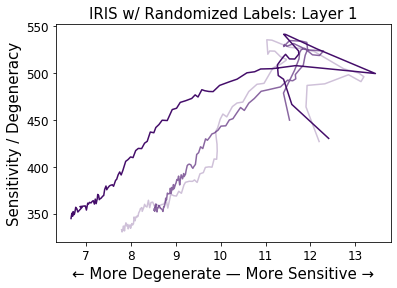

In [32]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer1s = np.array([f['ei_layer1'] for f in run])
    sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
    degeneracy_layer1s = sensitivity_layer1s - ei_layer1s

#     diff = (sensitivity_layer1s[-1] - sensitivity_layer1s[0])
#     O = 75
    xS = sensitivity_layer1s
    yS = degeneracy_layer1s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(1, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer1s
#     yS = degeneracy_layer1s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Randomized Labels: Layer 1", fontsize=15)
plt.savefig("figures/iris_plane_layer1_randomized.png", dpi=300, bbox_inches='tight')

/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


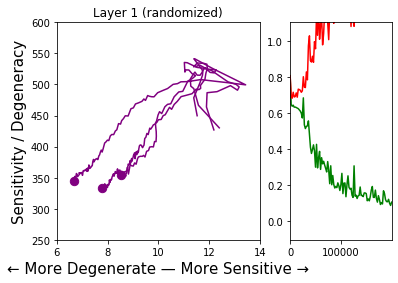

In [65]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 1 (randomized)")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([6, 14])
ax.set_ylim([250, 600])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer1_randomized.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer1s = np.array([f['ei_layer1'] for f in run])
            sensitivity_layer1s = np.array([f['sensitivity_layer1'] for f in run])
            degeneracy_layer1s = sensitivity_layer1s - ei_layer1s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer1s[-1] - sensitivity_layer1s[0])
            O = 50
            xS = sensitivity_layer1s
            yS = degeneracy_layer1s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)

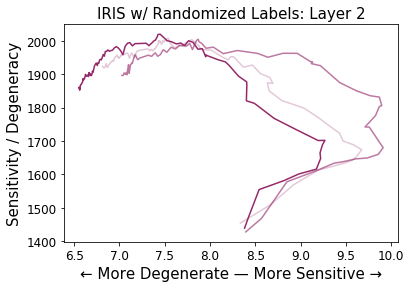

In [33]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer2s = np.array([f['ei_layer2'] for f in run])
    sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
    degeneracy_layer2s = sensitivity_layer2s - ei_layer2s

#     diff = (sensitivity_layer2s[-1] - sensitivity_layer2s[0])
#     O = 75
    xS = sensitivity_layer2s
    yS = degeneracy_layer2s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(2, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer2s
#     yS = degeneracy_layer2s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Randomized Labels: Layer 2", fontsize=15)
plt.savefig("figures/iris_plane_layer2_randomized.png", dpi=300, bbox_inches='tight')

/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


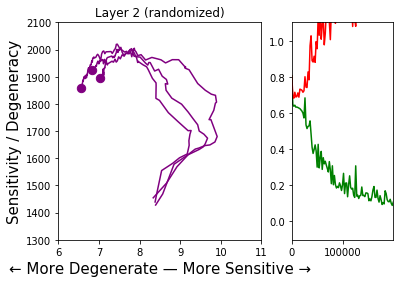

In [68]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 2 (randomized)")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([6, 11])
ax.set_ylim([1300, 2100])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer2_randomized.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer2s = np.array([f['ei_layer2'] for f in run])
            sensitivity_layer2s = np.array([f['sensitivity_layer2'] for f in run])
            degeneracy_layer2s = sensitivity_layer2s - ei_layer2s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer2s[-1] - sensitivity_layer2s[0])
            O = 50
            xS = sensitivity_layer2s
            yS = degeneracy_layer2s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)

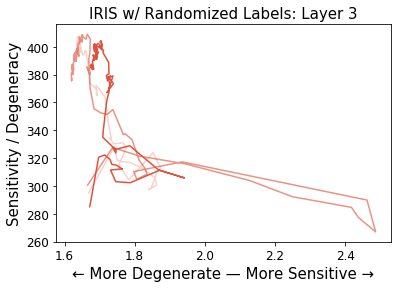

In [34]:
fig, ax = matplotlib.pyplot.subplots(1,1)  

for i, run in enumerate(runs):
    batches = [f['num_batches'] for f in run]
    ei_layer3s = np.array([f['ei_layer3'] for f in run])
    sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
    degeneracy_layer3s = sensitivity_layer3s - ei_layer3s

#     diff = (sensitivity_layer3s[-1] - sensitivity_layer3s[0])
#     O = 75
    xS = sensitivity_layer3s
    yS = degeneracy_layer3s
    xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
    line, = ax.plot(xPrime, yPrime, c=infernoMap(3, 3), alpha=0.25+0.37*i)
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
    
    # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(2, 3))
#     if i == 0:
#         line.set_label("2")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))
#     xS = sensitivity_layer3s
#     yS = degeneracy_layer3s
#     xPrime = [numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     yPrime = [numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]
#     line, = ax.plot(xPrime[:O], yPrime[:O], c=infernoMap(3, 3))
#     if i == 0:
#         line.set_label("3")
#     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
#     # lineO, = ax.plot(xPrimeo[:], yPrimeo[:], c = makeColor(range(len(sens[0])), index, colors["overfit"]))


#ax.set_xlabel('Epoch',fontsize=15)            
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
# ax.set_xlim([-0.34,0.6])
# ax.set_ylim([5,25])
#ax.set_ylim([0,70])
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})
ax.tick_params(axis='both',which='major',labelsize=12)
plt.title("IRIS w/ Randomized Labels: Layer 3", fontsize=15)
plt.savefig("figures/iris_plane_layer3_randomized.png", dpi=300, bbox_inches='tight')

/home/eric/Code/miniconda3/envs/deep-ei/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


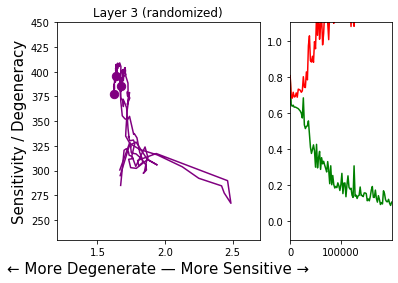

In [70]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=8, metadata=metadata)

fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
ax.set_title("Layer 3 (randomized)")
ax.set_ylabel('Sensitivity / Degeneracy',fontsize=15)
ax.set_xlabel("← More Degenerate — More Sensitive →", fontsize = 15)
ax.set_xlim([1.2, 2.7])
ax.set_ylim([230, 450])
# ax2.set_yscale('log')
# Plot a vertical line!
#noEIChange, = ax.plot([0,0],[-10,80],c = 'black')
# noEIChange, = ax.plot([0,0],[2,6], c='black')
# noEIChange.set_label("EI nullcline")
# Plot the legend!
# fig.legend(loc=(.18,0.645),prop={'size':10})
#fig.legend(loc=(.135,0.645),prop={'size':10})

ss = [ax.scatter([], [], c='purple', s=70) for _ in range(3)]
lines = [ax.plot([], [], c='purple')[0] for _ in range(3)]

tr_ls, = ax2.plot([], [], c='green', label='training loss')
te_ls, = ax2.plot([], [], c='red', label='testing loss')

# s = ax.scatter(xPrime[n:n+1], yPrime[n:n+1], c='purple', s=70)
# line, = ax.plot(xPrime[0:n+1], yPrime[0:n+1], c='purple')

with writer.saving(fig, "layer3_randomized.mp4", dpi=200):
    for n in range(l):
        for i, run in enumerate(runs):
            batches = [f['num_batches'] for f in run]
            ei_layer3s = np.array([f['ei_layer3'] for f in run])
            sensitivity_layer3s = np.array([f['sensitivity_layer3'] for f in run])
            degeneracy_layer3s = sensitivity_layer3s - ei_layer3s
            training_loss = np.array([f['training_loss'] for f in run])
            testing_loss = np.array([f['testing_loss'] for f in run])
#             diff = (sensitivity_layer3s[-1] - sensitivity_layer3s[0])
            O = 50
            xS = sensitivity_layer3s
            yS = degeneracy_layer3s
            xPrime = np.array([numpy.cos(numpy.pi/4)*x - numpy.sin(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            yPrime = np.array([numpy.sin(numpy.pi/4)*x + numpy.cos(numpy.pi/4)*y for x,y in zip(xS,yS)]) #/ diff
            ss[i].set_offsets([xPrime[n], yPrime[n]])
            lines[i].set_data(xPrime[0:n+1], yPrime[0:n+1])
        tr_ls.set_data(batches[0:n+1], training_loss[0:n+1])
        te_ls.set_data(batches[0:n+1], testing_loss[0:n+1])
        ax2.set_xlim(0, batches[n])
        #     if i == 0:
        #         line.set_label("1")
        #     line, = ax.plot(xPrime[O:], yPrime[O:], c='green')
        #ax.set_xlabel('Epoch',fontsize=15)            
        
        writer.grab_frame()
#         fig, ax = matplotlib.pyplot.subplots(1,1)